In [16]:
import pandas as pd
import numpy as np
from itertools import groupby
import pickle
import sys
import os
path = "/home/piotr/projects/twitter"
sys.path.append(os.path.join(path, "src"))
from twitter_tools.utils import read_files
from tqdm.notebook import tqdm
import ast
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
opp_sample = pickle.load(open(os.path.join(path, "data/sample/opp_sample.pickle"),"rb"))
gov_sample = pickle.load(open(os.path.join(path, "data/sample/gov_sample.pickle"),"rb"))
path_clean = os.path.join(path, "data/clean")

In [18]:
for dat in tqdm(read_files(path, 85, dtype = {"retweeted_status-user-id_str":str, 
                                             "id_str":str,
                                            "user-id_str":str,
                                            "retweeted_status-id_str":str})):
    
    #drop English tweets
    dat = dat[np.logical_not(dat.english)]
    
    #how many retweets from opp and gov users
    dat.loc[:, ("opp_retweet")] = dat["retweeted_status-user-id_str"].apply(lambda x: x in opp_sample)
    dat.loc[:, ("gov_retweet")] = dat["retweeted_status-user-id_str"].apply(lambda x: x in gov_sample)
    
    #how many retweets were retweeted from each user by users in sample
    rt = dat.groupby(["source","retweeted_status-user-id_str"]).sum()
    rt = list(rt.to_dict().values())[0]
    rt_dict = {g: {k[1]:v for k, v in elem} for g, elem in groupby(rt.items(), lambda x: x[0][0])}
    dat.loc[:, ("opp_retweet_from")] = dat["user-id_str"].map(rt_dict["opp"]) #number retweeted from opp
    dat.loc[:, ("gov_retweet_from")] = dat["user-id_str"].map(rt_dict["gov"]) #number retweeted from gov
    dat.loc[:, ("retweet_from")] = dat[["opp_retweet_from","gov_retweet_from"]].sum(axis = 1) #total retweeted
    
    dat.loc[:, ("tweet_len")] = dat["full_text"].str.split().apply(len) #tweet length
    dat.loc[:, ("ntokens")] = dat["preprocessed"].apply(lambda x: len(ast.literal_eval(x))) #num tokens prep
    
    #aggregate - total tweet number
    retweets = dat.groupby(["user-id_str", "day", "source"]).agg({"gov_retweet":["sum"], 
                                                                  "opp_retweet":["sum"], 
                                                                  "opp_retweet_from":["sum"],
                                                                  "gov_retweet_from":["sum"],
                                                                  "retweet_from":["sum"],
                                                                  "full_text":["count"],
                                                                  "ntokens":["mean"],
                                                                  "tweet_len":["mean"],
                                                                  "user-friends_count":["max"],
                                                                  "user-followers_count":["max"]})
    retweets.columns = retweets.columns.get_level_values(0)
    retweets.reset_index(inplace = True)
    retweets.reset_index(inplace = True)
    if os.path.isfile(os.path.join(path, "data/overview.csv")):
        retweets.to_csv(os.path.join(path, "data/overview.csv"), mode = "a", header = False)
    else:
        retweets.to_csv(os.path.join(path, "data/overview.csv"), mode = "w")

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [56]:
df = pd.read_csv("overview.csv", index_col = 0)
df["user-id_str"] = df["user-id_str"].astype(str)

In [57]:
info = pd.DataFrame()
path = "/home/piotr/projects/twitter/data/sample/"
cols = ["id_str","location","name","screen_name"]
for src in ["gov","opp"]:
    tmp = pd.read_csv(os.path.join(path, src + "_partisans_info.csv"), index_col = 0)
    tmp = tmp[cols]
    tmp["source"] = src
    info = info.append(tmp)
info.columns = ["user-id_str","location","name","screen_name","source"]
info["user-id_str"] = info["user-id_str"].astype(str)

In [58]:
df = pd.merge(df, info, how = "left", on = ["source","user-id_str"])

In [101]:
import re
opposition = ['@SchetynadlaPO', '@bbudka', '@KLubnauer', '@Arlukowicz', 
              '@profGrodzki', '@RyszardPetru', '@trzaskowski_', 
              '@TomaszSiemoniak', '@Gasiuk_Pihowicz']
opposition = list(map(lambda x: re.sub("@","",x), opposition))
government = ['@D_Tarczynski', '@BeataSzydlo', '@Macierewicz_A', 
              '@KrystPawlowicz', '@StKarczewski', '@MorawieckiM', 
              '@ZiobroPL', '@jbrudzinski', '@PatrykJaki', '@mblaszczak']
government = list(map(lambda x: re.sub("@","",x), government))

In [102]:
set(df.screen_name.unique()).intersection(opposition)

{'Arlukowicz', 'TomaszSiemoniak'}

In [103]:
set(df.screen_name.unique()).intersection(government)

{'D_Tarczynski', 'jbrudzinski', 'mblaszczak'}

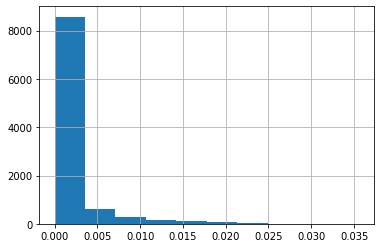

In [110]:
tweet_counts = df.groupby(["screen_name","source"]).agg({"full_text":["sum"]})
tweet_counts.columns = tweet_counts.columns.get_level_values(0) #reset multiindex
tweet_counts["prop"] = tweet_counts["full_text"]/df.shape[0]
tweet_counts.reset_index(inplace = True)
tweet_counts.prop.hist()
plt.show()

In [111]:
tweet_counts.groupby("source").apply(lambda x: x.nlargest(20, ["prop"]))

screen_name source  full_text      prop
source                                                  
gov    5281  Tadeusz87434686    gov      12711  0.035566
       7053          halmys1    gov      11793  0.032997
       7100          i_prawo    gov      10421  0.029158
       9537        urwis1977    gov      10368  0.029010
       283   Agniesz12815786    gov      10055  0.028134
       4667           RadcaW    gov       9448  0.026436
       7200         jacekbea    gov       9329  0.026103
       2351  Jolanta6Jolanta    gov       8900  0.024903
       6028        aliska541    gov       8775  0.024553
       8030     majowski1959    gov       8571  0.023982
       6130       anni211121    gov       8469  0.023697
       7636      konsul_1989    gov       8317  0.023271
       3946        MruczinoM    gov       8298  0.023218
       9012       robertol04    gov       8275  0.023154
       7551          kazia40    gov       8242  0.023062
       4815         Robest64    gov       8099  0.022661
       9397      the_pogarda    gov       8008  0.022407
       1364        Dziobak11    gov       7979  0.022326
       7406     jozefbak1999    gov       7965  0.022286
       8840       politykova    gov       7952  0.022250
opp    6106         aniqua16    opp      12702  0.035541
       4775   Robert06270082    opp      10841  0.030334
       2623      Kauzyperda1    opp       9440  0.026414
       7058       happyedyta    opp       8936  0.025003
       9483    trueblue00000    opp       8826  0.024696
       3774    MichalOleksyn    opp       8617  0.024111
       6884     freedom1970a    opp       8580  0.024007
       574      Archie_Choar    opp       8411  0.023534
       195      Adam83462787    opp       8331  0.023311
       8291    michal_hadron    opp       8293  0.023204
       6311        beatax088    opp       8259  0.023109
       3790  Michaldomagala2    opp       7908  0.022127
       1415     Ekka68910694    opp       7869  0.022018
       2811       Krzysiek_K    opp       7858  0.021987
       2977  LeszekGrabarczy    opp       7822  0.021886
       7305          jarkono    opp       7790  0.021797
       9178         smnelken    opp       7715  0.021587
       3334   ManOfWorseSort    opp       7673  0.021469
       9435        tomaszdac    opp       7645  0.021391
       6149         apawa137    opp       7644  0.021388

In [114]:
followers_counts = df.groupby(["screen_name","source"]).agg({"user-followers_count":["mean"]})
followers_counts.columns = followers_counts.columns.get_level_values(0) #reset multiindex
followers_counts.reset_index(inplace = True)
followers_counts.describe().astype(np.int64)

,user-followers_count
count,9831
mean,1147
std,20065
min,0
25%,13
50%,68
75%,335
max,1131336


In [113]:
followers_counts.groupby("source").apply(lambda x: x.nlargest(20, ["user-followers_count"]))

screen_name source  user-followers_count
source                                                   
gov    422       AndrzejDuda    gov          1.117422e+06
       2532    KarenJeanHood    gov          2.091445e+05
       8247       mblaszczak    gov          1.104282e+05
       7327      jbrudzinski    gov          1.053001e+05
       3466  MarekKuchcinski    gov          7.595088e+04
       9628           wipler    gov          7.588675e+04
       1102     D_Tarczynski    gov          6.844764e+04
       8513     niezaleznapl    gov          5.363679e+04
       2913   KvvKwiatkowski    gov          4.607752e+04
       6732         ecrgroup    gov          3.819333e+04
       6289  batofthedungeon    gov          3.482119e+04
       5479  TygodnikLisicki    gov          3.279128e+04
       6774    elzbietawitek    gov          2.722292e+04
       3975     NFZ_Centrala    gov          2.577548e+04
       1244      Defence24pl    gov          2.543776e+04
       6285         baspiela    gov          2.467704e+04
       5539         WBiedron    gov          2.418050e+04
       8300   michaldworczyk    gov          2.402977e+04
       6949        girzynski    gov          2.252371e+04
       9701   wsrnevergiveup    gov          2.128146e+04
opp    6677       donaldtusk    opp          1.131336e+06
       6932  gazeta_wyborcza    opp          7.677548e+05
       2236  JaroslawKuzniar    opp          6.048622e+05
       2272       JerzyBuzek    opp          3.583981e+05
       2921     LBalcerowicz    opp          3.265692e+05
       8694        pawelgras    opp          1.476205e+05
       1380              EPP    opp          1.410144e+05
       599        Arlukowicz    opp          1.333065e+05
       4508    Platforma_org    opp          1.304969e+05
       4463   PiotrWeresniak    opp          1.123572e+05
       6254  barbaraanowacka    opp          1.006308e+05
       5404  TomaszSiemoniak    opp          9.457485e+04
       5649           Wimmer    opp          8.972520e+04
       425    AndrzejHalicki    opp          6.186971e+04
       7280     janrostowski    opp          5.540180e+04
       3122      MKierwinski    opp          4.452311e+04
       4804     RobertReives    opp          4.208806e+04
       8888   psiquiatriacom    opp          3.937341e+04
       2686      Kom_Obr_Dem    opp          3.713717e+04
       4196    PSzubartowicz    opp          3.348777e+04

The code below was used to fix missing variable from the main dataset: